In [1]:
import metalearning_benchmarks.line_sine1d_benchmark
import torch
import wandb
from config import Config, DataConfig, ModelConfig, TrainValConfig
from decoder import Decoder
from deterministic_encoder import DeterministicEncoder
from diffusion_process import DIS
from encoder import Encoder
from latent_encoder import LatentEncoder, z_tuple
from matplotlib import pyplot as plt
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from neural_process import NeuralProcess
from train_val import train_and_validate
from utils import DataModule, MetaLearningDataset, split_context_target
from visualize import visualize_batch_1d

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
data_config = DataConfig(
    benchmark="LineSine1D",
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

model_config = ModelConfig(
    x_dim=1,
    y_dim=1,
    r_dim=2,
    z_dim=2,
    h_dim=128,
    num_layers_det_enc=3,
    num_layers_lat_enc=3,
    num_layers_dec=3,
    non_linearity="SiLU",
    is_attentive=False,
    aggregation="mean",
    fixed_start_density=True,
    diffusion_process="DIS",
    num_steps=16,
    num_layers_diffu_process=3,
)

train_val_config = TrainValConfig(
    batch_size=128,
    num_epochs=100,
    learning_rate=3e-5,
    split=(0.8, 0.2)
)

config = Config(
    data_config=data_config,
    model_config=model_config,
    train_val_config=train_val_config
)

In [4]:
benchmark = getattr(metalearning_benchmarks.line_sine1d_benchmark, config.data_config.benchmark)(
    n_task=config.data_config.n_task,
    n_datapoints_per_task=config.data_config.n_datapoints_per_task,
    output_noise=config.data_config.output_noise,
    seed_task=config.data_config.seed_task, 
    seed_x=config.data_config.seed_x, 
    seed_noise=config.data_config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.train_val_config.batch_size,
    dataset_and_split=(dataset, config.train_val_config.split),
    num_workers=15
)

Generating tasks:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 286943.30it/s]


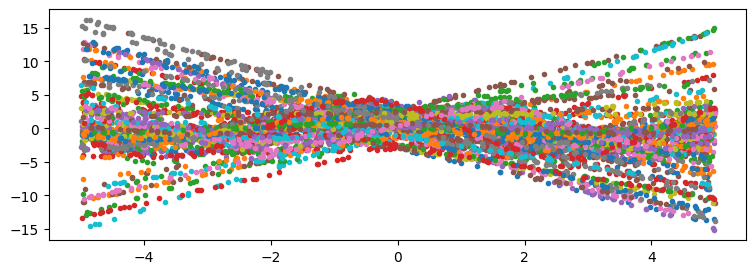

In [5]:
visualize_batch_1d(batch=next(iter(data_module.train_dataloader())))

In [6]:
diffu_process = DIS(
    device=device,
    num_steps=config.model_config.num_steps,
    z_dim=config.model_config.z_dim,
    h_dim=config.model_config.h_dim,
    num_layers=config.model_config.num_layers_diffu_process,
    non_linearity=config.model_config.non_linearity
)

# det_encoder = DeterministicEncoder(
#     x_dim=config.model_config.x_dim,
#     y_dim=config.model_config.y_dim,
#     h_dim=config.model_config.h_dim,
#     r_dim=config.model_config.r_dim,
#     num_layers=config.model_config.num_layers_det_enc,
#     non_linearity=config.model_config.non_linearity,
#     is_attentive=config.model_config.is_attentive,
#     aggregation=config.model_config.aggregation
# )

lat_enc = LatentEncoder(
    x_dim=config.model_config.x_dim,
    y_dim=config.model_config.y_dim,
    h_dim=config.model_config.h_dim,
    z_dim=config.model_config.z_dim,
    num_layers=config.model_config.num_layers_lat_enc,
    non_linearity=config.model_config.non_linearity,
    is_attentive=config.model_config.is_attentive,
    aggregation=config.model_config.aggregation,
    diffusion_process=diffu_process,
    fixed_start_density=config.model_config.fixed_start_density
)

enc = Encoder(
    deterministic_encoder=None, # det_encoder,
    latent_encoder=lat_enc
)

dec = Decoder(
    input_dim=config.model_config.x_dim + config.model_config.z_dim, # + config.model_config.r_dim,
    h_dim=config.model_config.h_dim,
    y_dim=config.model_config.y_dim,
    num_layers=config.model_config.num_layers_dec,
    non_linearity=config.model_config.non_linearity
)

neural_process = NeuralProcess(
    encoder=enc,
    decoder=dec,
).to(device)

optimizer = torch.optim.Adam(neural_process.parameters(), lr=config.train_val_config.learning_rate)

In [7]:
wandb_logging = False
if wandb_logging:
    wandb.init(project="np", config=config.asdict())

In [8]:
avg_train_log_likes = []
avg_train_priors_kls = []
avg_train_diffu_kls = []

avg_val_log_likes = []
avg_val_priors_kls = []
avg_val_diffu_loss = []

In [9]:
losses = train_and_validate(
    neural_process=neural_process,
    device=device,
    data_module=data_module,
    optimizer=optimizer,
    num_epochs=config.train_val_config.num_epochs,
    wandb_logging=wandb_logging,
)

avg_train_log_likes.extend(losses[0])
avg_train_priors_kls.extend(losses[1])
avg_train_diffu_kls.extend(losses[2])

if losses[3] is not None: avg_val_log_likes.extend(losses[3])
if losses[4] is not None: avg_val_priors_kls.extend(losses[4])
if losses[5] is not None: avg_val_diffu_loss.extend(losses[5])

  0%|          | 0/26 [00:00<?, ?it/s]/home/chickencurry/diffusion-vi-neural-processes/neural-process/code/new/components/latent_encoder.py:101: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  z = torch.normal(z_mu, z_sigma).to(h.device)
  4%|▍         | 1/26 [00:00<00:18,  1.32it/s, diffu_kl=2.79e+4, epoch=0, log_like=-8.86e+3, loss=3.67e+4, priors_kl=0]

1.0000300407409668


  8%|▊         | 2/26 [00:01<00:13,  1.79it/s, diffu_kl=4.1e+4, epoch=0, log_like=-1.02e+4, loss=5.11e+4, priors_kl=0] 

1.000058650970459


 12%|█▏        | 3/26 [00:01<00:10,  2.15it/s, diffu_kl=3.32e+4, epoch=0, log_like=-3.24e+4, loss=6.56e+4, priors_kl=0]

1.0000723600387573


 15%|█▌        | 4/26 [00:01<00:09,  2.40it/s, diffu_kl=3.62e+4, epoch=0, log_like=-605, loss=3.68e+4, priors_kl=0]    

1.0000925064086914


 19%|█▉        | 5/26 [00:02<00:08,  2.51it/s, diffu_kl=3.04e+4, epoch=0, log_like=-7.48e+3, loss=3.79e+4, priors_kl=0]

1.0001156330108643


 23%|██▎       | 6/26 [00:02<00:07,  2.62it/s, diffu_kl=4.03e+4, epoch=0, log_like=-1.3e+3, loss=4.16e+4, priors_kl=0] 

1.000140905380249


 27%|██▋       | 7/26 [00:02<00:07,  2.69it/s, diffu_kl=2.61e+4, epoch=0, log_like=-2.07e+3, loss=2.82e+4, priors_kl=0]

1.000166893005371


 31%|███       | 8/26 [00:03<00:06,  2.73it/s, diffu_kl=5.96e+4, epoch=0, log_like=-813, loss=6.04e+4, priors_kl=0]    

1.00019371509552


 35%|███▍      | 9/26 [00:03<00:06,  2.77it/s, diffu_kl=4.23e+4, epoch=0, log_like=-574, loss=4.29e+4, priors_kl=0]

1.0002211332321167


 38%|███▊      | 10/26 [00:03<00:05,  2.79it/s, diffu_kl=4.05e+4, epoch=0, log_like=-1.15e+4, loss=5.2e+4, priors_kl=0]

1.000246286392212


 42%|████▏     | 11/26 [00:04<00:05,  2.80it/s, diffu_kl=5.56e+4, epoch=0, log_like=-2.07e+3, loss=5.77e+4, priors_kl=0]

1.000272274017334


 46%|████▌     | 12/26 [00:04<00:04,  2.83it/s, diffu_kl=2.52e+4, epoch=0, log_like=-1.02e+3, loss=2.62e+4, priors_kl=0]

1.0002986192703247


 50%|█████     | 13/26 [00:05<00:04,  2.84it/s, diffu_kl=2.5e+4, epoch=0, log_like=-3.33e+3, loss=2.84e+4, priors_kl=0] 

1.0003256797790527


 54%|█████▍    | 14/26 [00:05<00:04,  2.84it/s, diffu_kl=2.54e+4, epoch=0, log_like=-1.31e+3, loss=2.67e+4, priors_kl=0]

1.000353217124939


 58%|█████▊    | 15/26 [00:05<00:03,  2.84it/s, diffu_kl=2.33e+4, epoch=0, log_like=-798, loss=2.41e+4, priors_kl=0]    

1.0003812313079834


 62%|██████▏   | 16/26 [00:06<00:03,  2.84it/s, diffu_kl=2.77e+4, epoch=0, log_like=-487, loss=2.82e+4, priors_kl=0]

: 

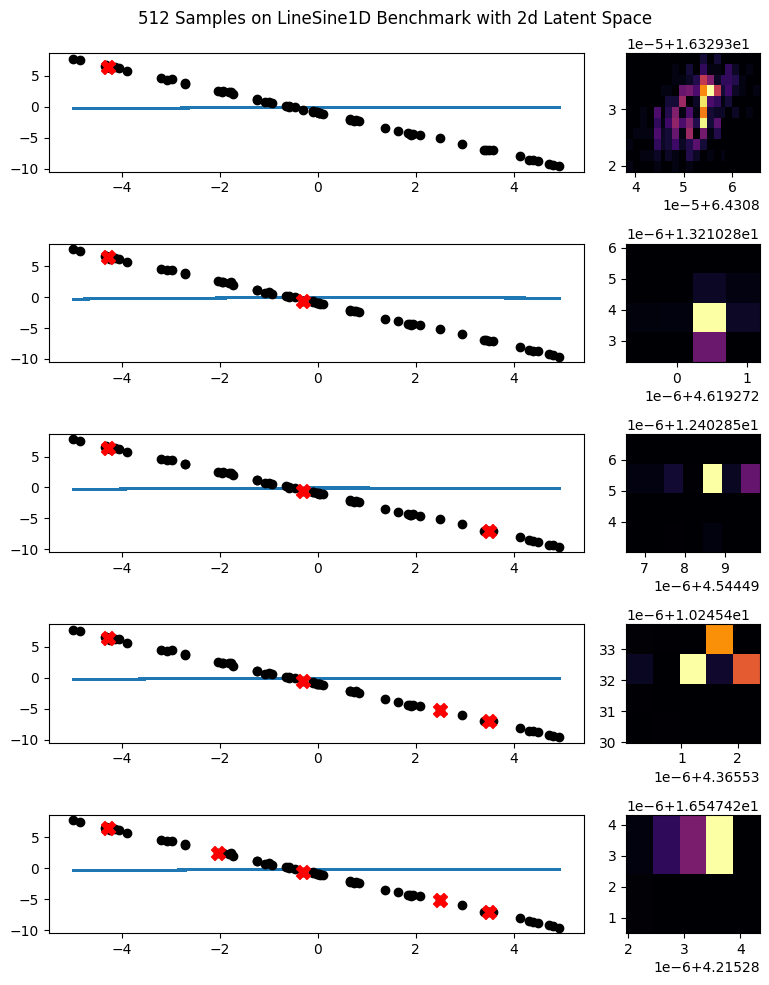

In [14]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)
x_data, y_data = next(iter(gen_dataloader))
x_data = x_data.to(device)
y_data = y_data.to(device)

context_lens = [1, 2, 3, 4, 5] # x_data.shape[1] - 1

n_samples = 512

fig, ax  = plt.subplots(len(context_lens), 2, figsize=(8, 2 * len(context_lens)), gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle(f"{n_samples} Samples on {config.data_config.benchmark} Benchmark with 2d Latent Space")

for i, context_len in enumerate(context_lens):

    x_context, y_context, _, _ = split_context_target(x_data, y_data, context_len=context_len, random=False)
    
    neural_process.eval()
    with torch.no_grad():
        
        _, y_mu, _, z_tuples = neural_process.sample(x_context, y_context, x_data, n_samples)

        x_data_sorted, indices = x_data.sort(dim=1)
        indices = indices.squeeze(0).squeeze(1)
        x_data_sorted = x_data_sorted.cpu().detach().numpy()
        y_data_sorted = y_data[:, indices, :].cpu().detach().numpy()
        y_mu_sorted = y_mu[:, indices, :].cpu().detach().numpy()

        for k in range(n_samples):
            ax[i][0].plot(x_data_sorted.squeeze(0).squeeze(1), y_mu_sorted[k].squeeze(1), alpha=0.2, c="tab:blue", zorder=0)

        ax[i][0].scatter(x_data_sorted, y_data_sorted, marker="o", c="black", zorder=1)
        ax[i][0].scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="X", c="red", s=100, zorder=2)

        ax[i][1].hist2d(z_tuples[-1].z[:, 0].cpu().detach().numpy(), z_tuples[-1].z[:, 1].cpu().detach().numpy(), bins=20, cmap="inferno")
        
        # ax[i][1].set_xlim(-10, 10)
        # ax[i][1].set_ylim(-10, 10)
        # if i != 0:
        #     ax[i][1].sharex(ax[0][1])
        #     ax[i][1].sharey(ax[0][1])


plt.tight_layout()
plt.show()